In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

# Описание задания
А/А-тестирование мобильного приложения. Необходимо посчитать результаты A/A-теста, проверяя метрику качества FPR (будем проверять на конверсии в покупку). Известно, что сплит-система сломана. Требуется проверить утверждение о поломке и найти ее причины, если сплит-система действительно сломана

# Загрузим данные

## Описание колонок
* **experimentVariant** – вариант эксперимента
* **version** – версия приложения
* **purchase** – факт покупки

In [12]:
df = pd.read_csv('hw_aa.csv', sep = ';', index_col=0)

## Посмотрим на данные и типы данных

In [14]:
print(f'''
количество строк: {df.shape[0]}
количество колонок: {df.shape[1]}
количество пропущенных значений: {df.isna().sum().sum()}
''')


количество строк: 127018
количество колонок: 4
количество пропущенных значений: 0



In [27]:
for c in df.columns:
    dtype = df[c].dtype
    nunique = df[c].nunique()
    unique = '[...]'
    if nunique <= 5:
       unique =  df[c].unique()
    print(f'{c}({dtype}) : {nunique} : {unique}')

uid(object) : 127018 : [...]
experimentVariant(int64) : 2 : [1 0]
version(object) : 4 : ['v2.8.0' 'v2.9.0' 'v3.7.4.0' 'v3.8.0.0']
purchase(int64) : 2 : [0 1]


# Задача 1
Запустите A/A-тест


Разделим выборки на **a1** и **a2**

In [28]:
a1 = df.query('experimentVariant == 0').purchase
a2 = df.query('experimentVariant == 1').purchase

In [30]:
# определим функцию для запуска A/A теста, визуализации полученных p-value
def get_fpr(a1: pd.Series, a2: pd.Series, simulations: int, n_s: int):
    # Запуск симуляций A/A теста
    for i in tqdm(range(simulations)):
        s1 = a1.sample(n_s, replace = False).values
        s2 = a2.sample(n_s, replace = False).values
        res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

    # визуализация
    plt.hist(res, bins = 50)
    plt.style.use('ggplot')
    plt.xlabel('pvalues')
    plt.ylabel('frequency')
    plt.title("Histogram of ttest A/A simulations ")
    plt.show()

    return res

In [33]:
# обределим функцию для проверки ложноположительных случаев
def get_wrong_alpha_level(fpr, alpha_levels):
    alphas = {}

    # Проверяем, что количество ложноположительных случаев не превышает альфа
    for a in alpha_levels:
        alphas[a] = sum(np.array(fpr) < a) / simulations
        if a < alphas[a]:
            print(f'количество ложноположительных случаев превышает альфа {a} < {alphas[a]}')
    
    return alphas

100%|██████████| 1000/1000 [00:06<00:00, 148.58it/s]


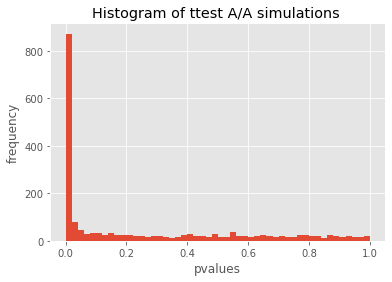

In [32]:
simulations = 1000
n_s = 1000
fpr = get_fpr(a1, a2, simulations, n_s)

# Задача 2
Посчитайте FPR на уровне альфа = 0.05 (ставьте подвыборки без возвращения объемом 1000). Вы увидите, что FPR > альфа! Нам нужно наоборот – чтобы было меньше.

In [35]:
# alphas = [0.01, 0.02, 0.03, 0.04, 0.05]
alphas = [0.05]
get_wrong_alpha_level(fpr, alphas)

количество ложноположительных случаев превышает альфа 0.05 < 0.974


{0.05: 0.974}

Видно, что результат согласуется с заданием **FPR** для *0.05* равен *0.974*, что больше *0.05* и у казывает на то, что выборки не сохожи между собой. Нужно искать причины!

# Задача 3
Найдите причины поломки сплит-системы, ориентируясь на результаты эксперимента (подсказка: найдите аномалию в версии приложения)